In [1]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

# 1. Define the DOE's parameters and optimization target

In [2]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': 2,
    'height_constraint_max': 1 * mm,
    'tolerance': 0.05 * mm,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

In [3]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
def define_FoM(resolution, sampling_size, wavelength, focal_length, position):
    """
    Calculates the Full-width-at-half-maximum (FWHM) by the far-field diffraction limit
    and applies it to model the point spread function (PSF) as a Gaussian function, with consistent intensity across positions.
    
    Parameters:
        resolution (tuple): The resolution of the field in pixels (height, width).
        sampling_size (float): The physical size of each pixel, in meters.
        wavelength (float): The wavelength of the light, in meters.
        focal_length (float): The focal length of the optical system, in meters.
        position (tuple): The target position in the field, in meters (x, y).
        
    Returns:
        torch.Tensor: The calculated and normalized PSF as a 2D Gaussian function over the specified field.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    height, width = resolution
    Length_x = sampling_size * width
    Length_y = sampling_size * height
    
    effective_L = torch.sqrt(torch.tensor((Length_x ** 2 + Length_y ** 2), device=device))
    NA = torch.sin(torch.atan(effective_L / (2 * focal_length)))
    FWHM = wavelength / (2 * NA)
    
    x_grid, y_grid = torch.meshgrid(torch.linspace(-Length_x / 2, Length_x / 2, steps=width, device=device),
                                    torch.linspace(-Length_y / 2, Length_y / 2, steps=height, device=device))
    
    x_position, y_position = torch.tensor(position, device=device)
    
    # Calculate the Gaussian PSF
    PSF = torch.exp(-((x_grid - x_position) ** 2 + (y_grid - y_position) ** 2) / ((FWHM*2) ** 2))
    
    # Normalize the PSF such that its maximum value is 1
    
    return normalize(PSF.unsqueeze(0).unsqueeze(0))

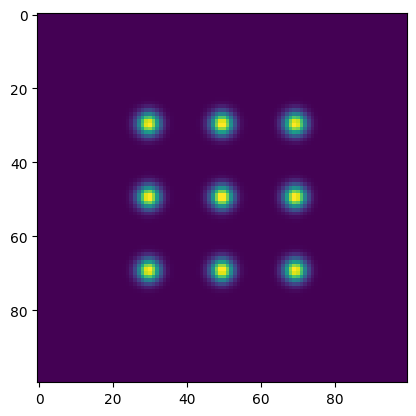

In [4]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, -20*mm])

PSF_2 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 20*mm])

PSF_3 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 20*mm])

PSF_4 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, -20*mm])

PSF_5 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, 0*mm])

PSF_6 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, -20*mm])

PSF_7 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 0*mm])

PSF_8 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, 20*mm])

PSF_9 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 0*mm])

target = PSF_1 + PSF_2 + PSF_3 + PSF_4 + PSF_5 + PSF_6 + PSF_7 + PSF_8 + PSF_9
plt.imshow(target[0, 0, :, :].cpu())

# 2. Define the System with SoftGumbelQuantizedDOE 

In [5]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [6]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [7]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.04110557585954666
The iteration : 200, Loss: 0.003374984720721841
The iteration : 400, Loss: 0.000850122538395226
The iteration : 600, Loss: 0.00042377307545393705
The iteration : 800, Loss: 0.0002887171576730907
The iteration : 1000, Loss: 0.00021962232131045312
The iteration : 1200, Loss: 0.00017216110427398235
The iteration : 1400, Loss: 0.00012928422074764967
The iteration : 1600, Loss: 0.00011594204261200503
The iteration : 1800, Loss: 8.992766379378736e-05
The iteration : 2000, Loss: 0.0001375510182697326
The iteration : 2200, Loss: 0.00012471654918044806
The iteration : 2400, Loss: 0.00012403674190863967
The iteration : 2600, Loss: 0.00011295026342850178
The iteration : 2800, Loss: 0.0001123698239098303
The iteration : 3000, Loss: 9.54952192842029e-05
The iteration : 3200, Loss: 8.654339035274461e-05
The iteration : 3400, Loss: 8.593358506914228e-05
The iteration : 3600,

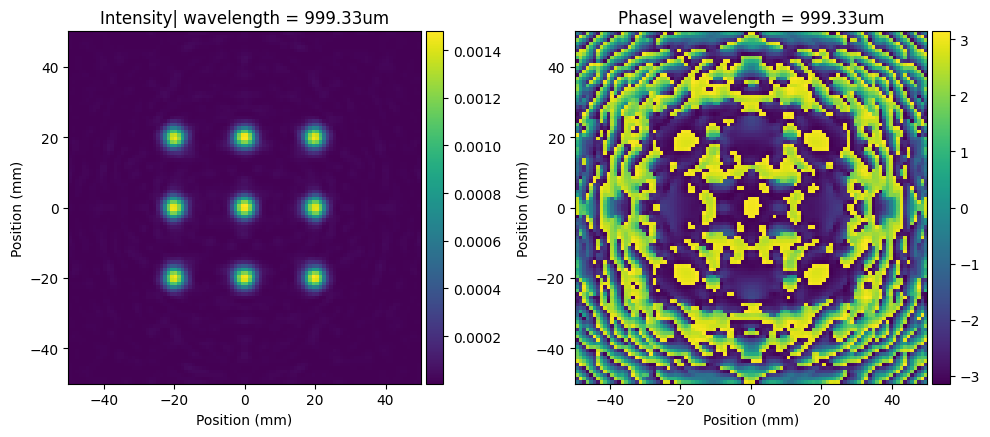

In [8]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

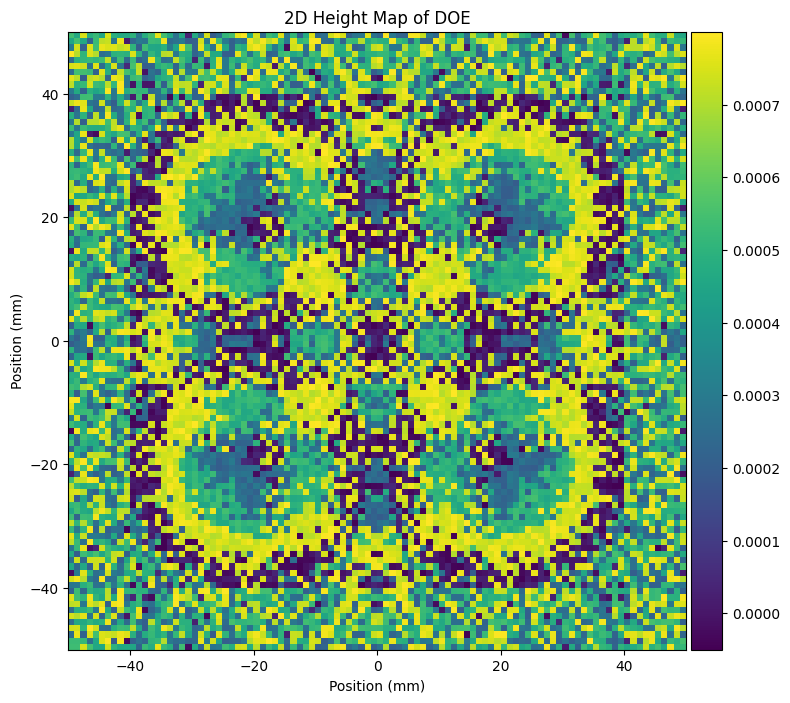

In [9]:
setup.doe.visualize(figsize=(8,8))

In [10]:
setup.doe.height_map.unique() / mm

#best_loss / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

# 3. Define the System with FullPrecisionDOE

In [11]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FullPrecisionDOELayer(self.doe_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [12]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [13]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.02623978815972805
The iteration : 200, Loss: 0.0028577425982803106
The iteration : 400, Loss: 0.001062468159943819
The iteration : 600, Loss: 0.0005364192184060812
The iteration : 800, Loss: 0.0003636586188804358
The iteration : 1000, Loss: 0.000266275746980682
The iteration : 1200, Loss: 0.0002161297743441537
The iteration : 1400, Loss: 0.00017727397789712995
The iteration : 1600, Loss: 0.00019146845443174243
The iteration : 1800, Loss: 0.00012299053196329623
The iteration : 2000, Loss: 0.0001067789999069646
The iteration : 2200, Loss: 9.92271670838818e-05
The iteration : 2400, Loss: 8.86289490154013e-05
The iteration : 2600, Loss: 9.739205415826291e-05
The iteration : 2800, Loss: 8.280303154606372e-05
The iteration : 3000, Loss: 8.050943142734468e-05
The iteration : 3200, Loss: 6.789866165490821e-05
The iteration : 3400, Loss: 6.042861787136644e-05
The iteration : 3600, Loss:

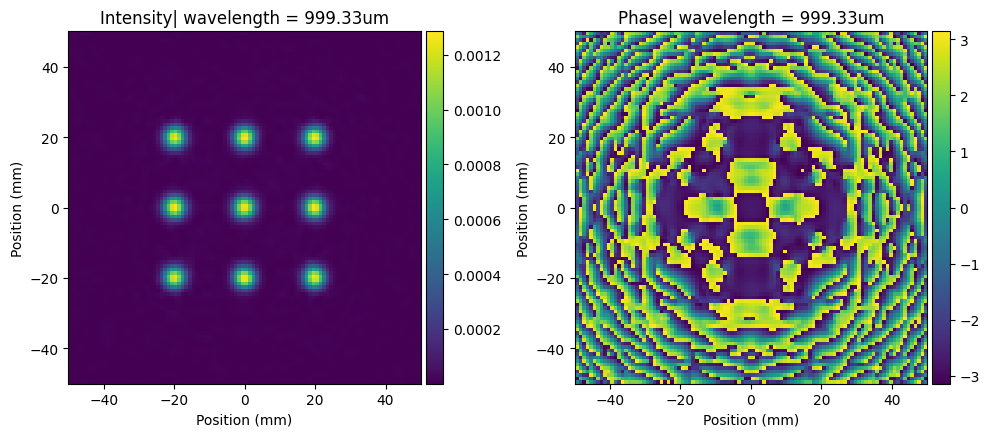

In [14]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

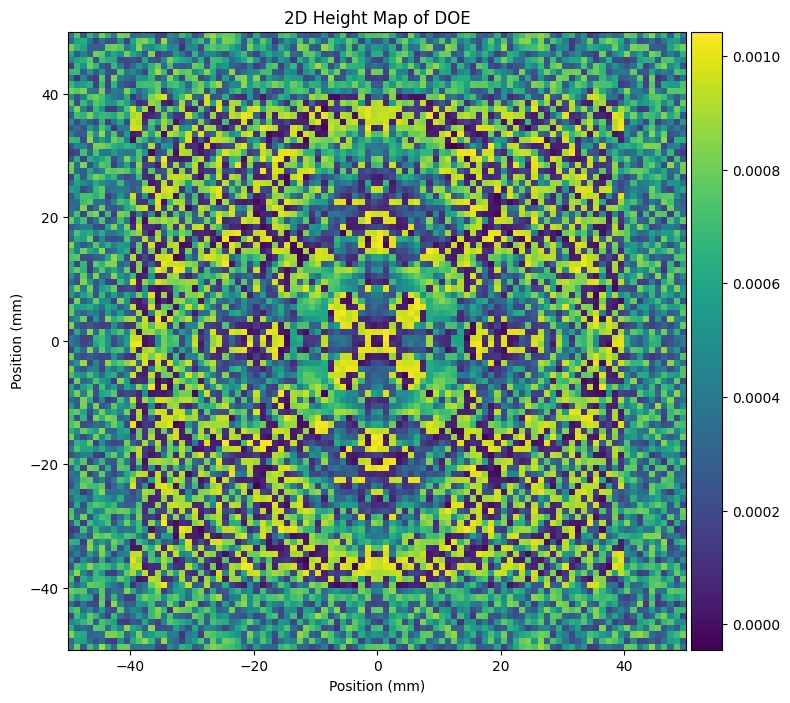

In [15]:
setup.doe.visualize(figsize=(8,8))

# 4. System with NaiveGumbelQuantizedDOELayer

In [16]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [17]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [18]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.039929911494255066
The iteration : 200, Loss: 0.01253384631127119
The iteration : 400, Loss: 0.010371081531047821
The iteration : 600, Loss: 0.009023768827319145
The iteration : 800, Loss: 0.008983390405774117
The iteration : 1000, Loss: 0.00637308694422245
The iteration : 1200, Loss: 0.004282812587916851
The iteration : 1400, Loss: 0.00406231451779604
The iteration : 1600, Loss: 0.0023211417719721794
The iteration : 1800, Loss: 0.0019731023348867893
The iteration : 2000, Loss: 0.0017722364282235503
The iteration : 2200, Loss: 0.0014387966366484761
The iteration : 2400, Loss: 0.001612866180948913
The iteration : 2600, Loss: 0.0016322307055816054
The iteration : 2800, Loss: 0.0012821091804653406
The iteration : 3000, Loss: 0.0012245167745277286
The iteration : 3200, Loss: 0.0016529422719031572
The iteration : 3400, Loss: 0.000676975876558572
The iteration : 3600, Loss: 0.0011769

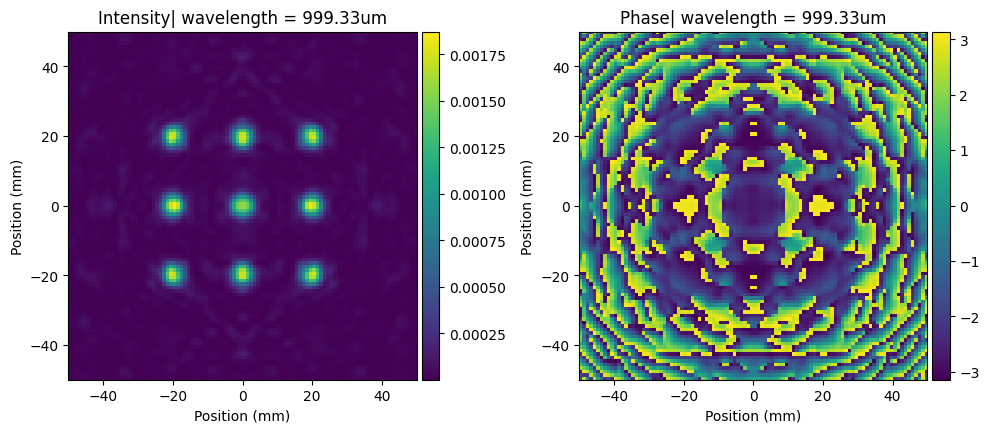

In [19]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

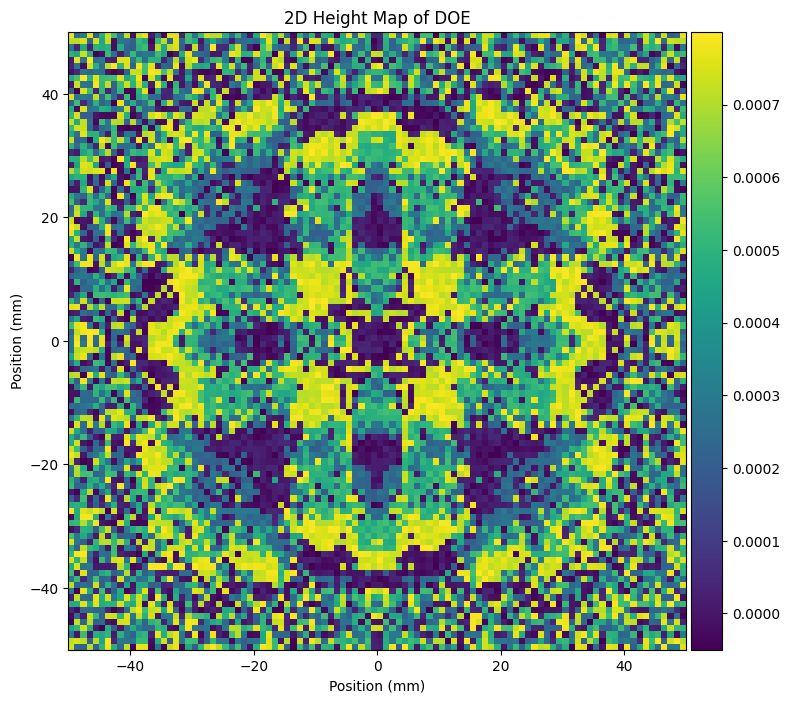

In [20]:
setup.doe.visualize(figsize=(8,8))

In [21]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

# 5. System with PSQuantizedDOELayer

In [22]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [23]:
optim_params = {
    'c_s': 300,
    'tau_max': 800,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [24]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.04677020013332367
The iteration : 200, Loss: 0.0069618248380720615
The iteration : 400, Loss: 0.006323955953121185
The iteration : 600, Loss: 0.00633880915120244
The iteration : 800, Loss: 0.006194163579493761
The iteration : 1000, Loss: 0.006237183231860399
The iteration : 1200, Loss: 0.006349196657538414
The iteration : 1400, Loss: 0.006240770686417818
The iteration : 1600, Loss: 0.006297444924712181
The iteration : 1800, Loss: 0.0062602912075817585
The iteration : 2000, Loss: 0.006301010958850384
The iteration : 2200, Loss: 0.0063124666921794415
The iteration : 2400, Loss: 0.006300859618932009
The iteration : 2600, Loss: 0.00627532321959734
The iteration : 2800, Loss: 0.0063659208826720715
The iteration : 3000, Loss: 0.0063674296252429485
The iteration : 3200, Loss: 0.006319047417491674
The iteration : 3400, Loss: 0.006268185097724199
The iteration : 3600, Loss: 0.0062033841

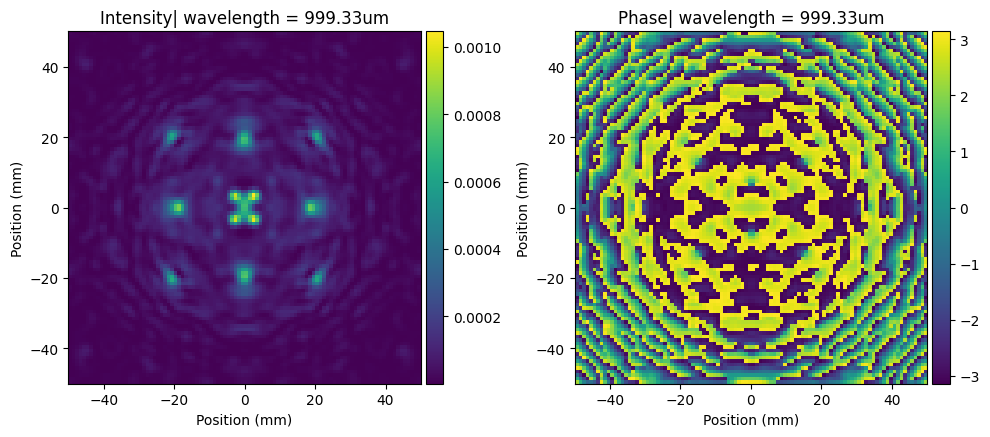

In [25]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

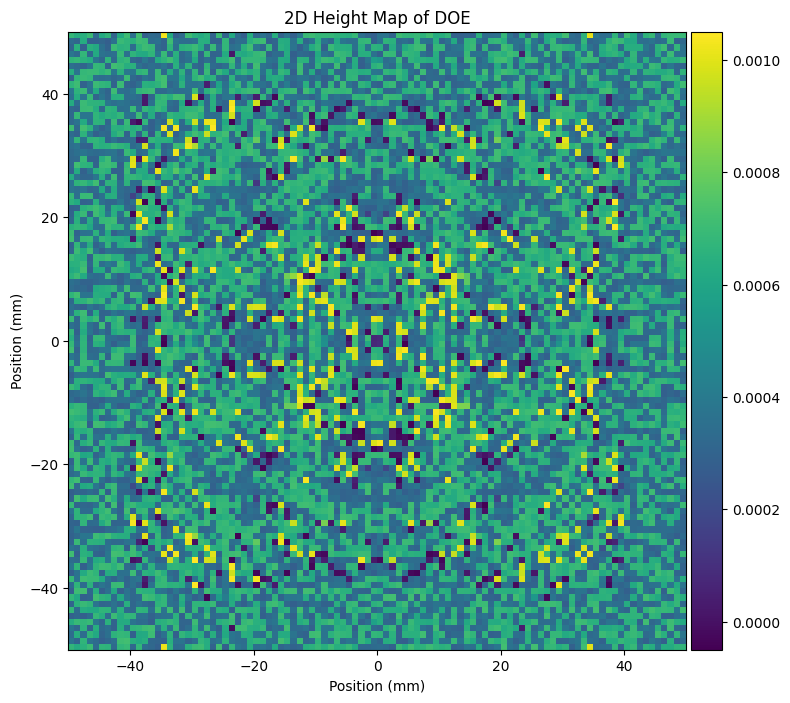

In [26]:
setup.doe.visualize(figsize=(8,8))

In [27]:
setup.doe.height_map.unique() / mm

tensor([5.8727e-38, 1.9642e-33, 5.0120e-29, 4.0134e-26, 1.6824e-24, 6.9079e-23,
        2.4090e-21, 1.4524e-13, 6.3855e-13, 3.2007e-12, 4.3506e-12, 1.3253e-11,
        2.1229e-10, 9.3208e-09, 3.5836e-08, 6.5783e-08, 6.7386e-08, 8.1382e-08,
        9.1625e-08, 1.0662e-07, 1.0863e-07, 1.1092e-07, 1.2911e-07, 1.3579e-07,
        1.5295e-07, 1.6212e-07, 1.8241e-07, 2.0879e-07, 2.1704e-07, 2.2277e-07,
        2.2473e-07, 2.2530e-07, 2.4671e-07, 2.6062e-07, 2.6510e-07, 2.8428e-07,
        2.8934e-07, 2.9210e-07, 2.9395e-07, 2.9397e-07, 3.0745e-07, 3.1618e-07,
        3.3161e-07, 3.4200e-07, 3.5440e-07, 3.6689e-07, 3.8246e-07, 3.8377e-07,
        3.8447e-07, 3.8909e-07, 4.1195e-07, 4.5581e-07, 4.6113e-07, 4.8115e-07,
        4.9006e-07, 4.9331e-07, 5.1007e-07, 5.2547e-07, 5.3745e-07, 5.4748e-07,
        5.7046e-07, 5.7219e-07, 5.7558e-07, 6.0945e-07, 6.3414e-07, 6.3594e-07,
        6.3692e-07, 6.4163e-07, 6.4299e-07, 6.4591e-07, 6.4911e-07, 6.4934e-07,
        6.6705e-07, 6.9337e-07, 7.2060e-

# 6. System with STEQuantizedDOELayer 

In [7]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [8]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [9]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.04189355671405792
The iteration : 200, Loss: 0.005234162788838148
The iteration : 400, Loss: 0.0014966686721891165
The iteration : 600, Loss: 0.0007952952291816473
The iteration : 800, Loss: 0.0006034461548551917
The iteration : 1000, Loss: 0.0007013717549853027
The iteration : 1200, Loss: 0.0007675380911678076
The iteration : 1400, Loss: 0.0003484068438410759
The iteration : 1600, Loss: 0.0004405697691254318
The iteration : 1800, Loss: 0.00028651885804720223
The iteration : 2000, Loss: 0.0002588806673884392
The iteration : 2200, Loss: 0.0004062218649778515
The iteration : 2400, Loss: 0.00038410205161198974
The iteration : 2600, Loss: 0.00023866943956818432
The iteration : 2800, Loss: 0.0002662919578142464
The iteration : 3000, Loss: 0.0001701108121778816
The iteration : 3200, Loss: 0.000195185566553846
The iteration : 3400, Loss: 0.00020193516684230417
The iteration : 3600, Lo

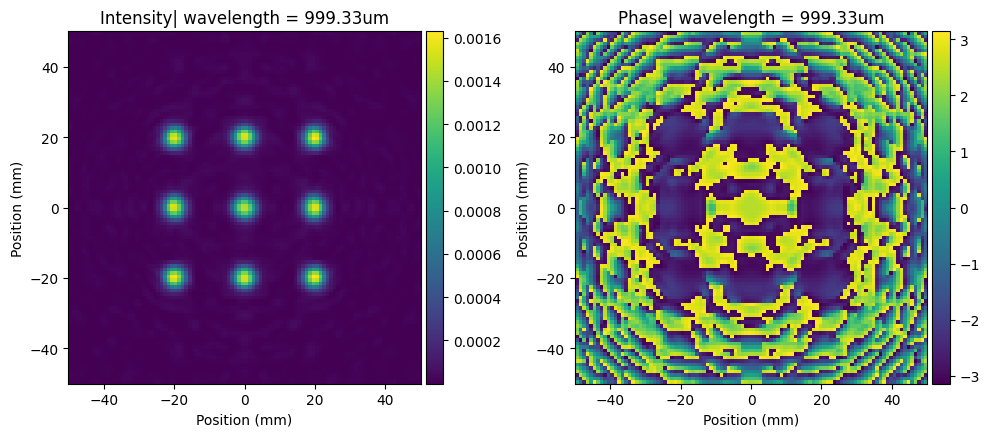

In [10]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

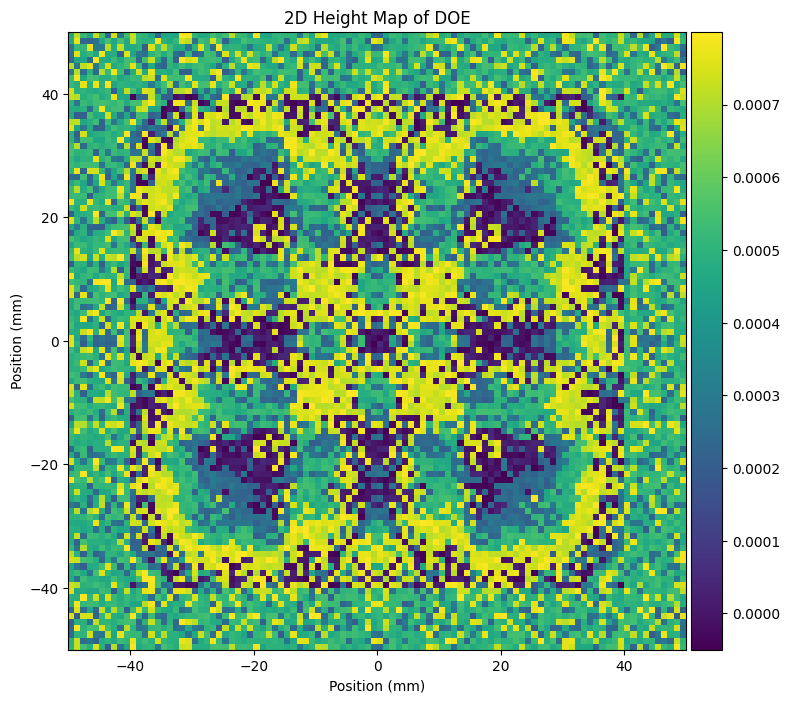

In [11]:
setup.doe.visualize(figsize=(8,8))

In [12]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

## 1. Visualize for 1D distribution intensity=

In [ ]:
out_amp = normalize(torch.abs(out_field.data)**2)

In [ ]:
# 1D distribution for spot 1 and 2
from utils.Visualization_Helper import float_to_unit_identifier, add_colorbar
size_x = np.array(1 * mm * 100 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
x_axis_spot_1_2 = out_amp[0, 0, :, 20]
x_axis_spot_1_2 = x_axis_spot_1_2.cpu().detach().numpy()
new_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_1_2))
plt.plot(new_x_axis, x_axis_spot_1_2)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")

plt.subplot(1, 2, 2)
x_axis_spot_3_4 = out_amp[0, 0, :, 80]
x_axis_spot_3_4 = x_axis_spot_3_4.cpu().detach().numpy()
plt.plot(new_x_axis, x_axis_spot_3_4)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")
plt.tight_layout()

## 2. Visualize for 2D quantized phase map of DOE

In [69]:
setup.hologram.q_phase.unique()

tensor([0.0000, 1.5708, 3.1416, 4.7124], device='cuda:0',
       grad_fn=<Unique2Backward0>)

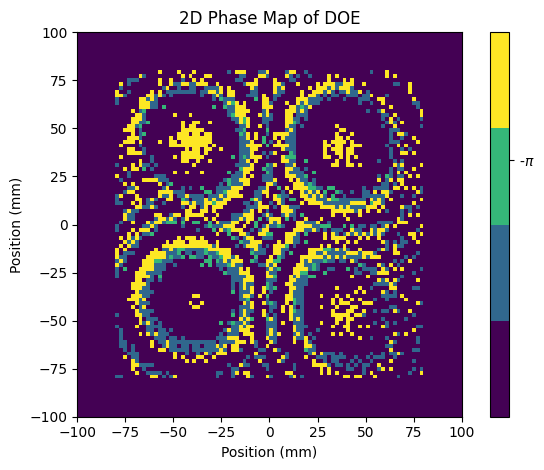

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

size_x = np.array(1 * mm * 200 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

extent = [-size_x, size_x, -size_x, size_x]

phase_map = setup.hologram.q_phase - 2 * torch.pi # 100 x 100
upsample_phase_map = nn.functional.interpolate(phase_map, size=[100, 100], mode='nearest')
#aperture = setup.hologram.Mask # 200 x 200
phase_map = upsample_phase_map
phase_map = phase_map.squeeze(0,1).detach().cpu().numpy()

cmap = plt.get_cmap('viridis', 4)
#bounds = np.linspace(-np.pi, np.pi, 5) # 9 boundaries for 8 discrete values

#norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

cax = ax.imshow(phase_map, extent=extent, cmap=cmap)
ax.set_title('2D Phase Map of DOE')
ax.set_xlabel("Position (" + unit_axis + ")")
ax.set_ylabel("Position (" + unit_axis + ")")

# Add a discrete colorbar with fractional π labels
ticks = np.linspace(-np.pi, np.pi, 5)
ticks = ticks[:-1]  # Positions for the ticks
tick_labels = ['-$\pi$', '-0.5$\pi$', '0', '0.5$\pi$']  # LaTeX formatted labels
cbar = fig.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)  # Set custom tick labels

plt.tight_layout()
plt.show()


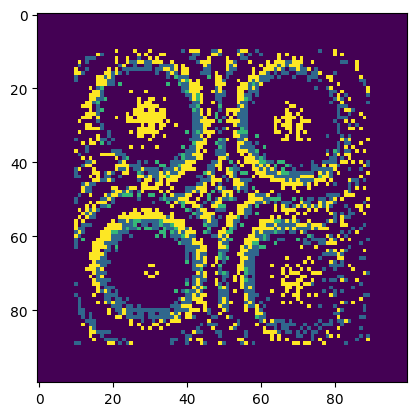

In [71]:
plt.imshow(phase_map)

In [34]:
bounds

NameError: name 'bounds' is not defined

In [84]:
ticks

array([-3.14159265, -1.04719755,  1.04719755,  3.14159265])

In [108]:
torch.rand(10)

tensor([0.7323, 0.4430, 0.5961, 0.7229, 0.5375, 0.6960, 0.0744, 0.9331, 0.0548,
        0.7367])